## Target Maximization

This section covers budget optimization by maximizing revenues with the insights from a fitted MMM and a user supplied LTV analysis (in channel level).

In revenue maximization, the objective function is define as

\begin{align*}
R & = \sum^K_k (\text{LTV}_k - \text{Cost per Acqusition}_k) \times \text{Attribution}_k \\
  & = \sum^K_k (\text{LTV}_k - \frac{\text{Spend}_k}{\text{Attribution}_k})  \times \text{Attribution}_k \\
  & = \sum^K_k (\text{LTV}_k \times \text{Attribution}_k  - \text{Spend}_k)
\end{align*}

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle

from karpiu.planning import RevenueMaximizer
from karpiu.planning.calculator import calculate_marginal_cost, generate_cost_report
from karpiu.explainability import Attributor

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [2]:
%load_ext autoreload
%autoreload 2

Bring back the fitted model from previous `Quickstart` section.

In [3]:
with open("./resource/model.pkl", "rb") as f:
    mmm = pickle.load(f)

In [4]:
budget_start = pd.to_datetime("2021-01-01")
budget_end = pd.to_datetime("2021-01-31")
optim_channels = mmm.get_spend_cols()
# to be safe in beta version, use sorted list of channels
optim_channels.sort()

# spend_scaler a fixed constant to reduce over-float of spend
# not that they need to be consistent with the subsequent calculation of
# post optimization metrics
spend_scaler = 1e3

In [5]:
optim_channels

['promo', 'radio', 'search', 'social', 'tv']

Given the customers life-time value (LTV), one can run the revenue maximization.

In [54]:
# ltv_arr = [15.5, 25.5, 30.6, 25.8, 20.8]
ltv_arr = [10.5, 18.5, 32.6, 20.8, 19.8]

In [55]:
df = mmm.get_raw_df()
init_spend_matrix = df.loc[
    (df["date"] >= budget_start) &
    (df["date"] <= budget_end),
    optim_channels
].values
init_spend_matrix.shape

(31, 5)

### Optimization Default Setting

In [56]:
maximizer = RevenueMaximizer(
    ltv_arr=ltv_arr,
    model=mmm,
    optim_channel=optim_channels,
    budget_start=budget_start,
    budget_end=budget_end,
    spend_scaler=10,
    response_scaler=10,
)
optim_spend_df = maximizer.optimize(maxiter=1000, eps=1e-3)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -51766.75215529797
            Iterations: 308
            Function evaluations: 47434
            Gradient evaluations: 304


In [57]:
optim_spend_matrix = maximizer.get_current_state()
init_spend_matrix = maximizer.get_init_state()

In [58]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(optim_spend_matrix)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 225823
Total Budget: 490508


#### Budget Allocation

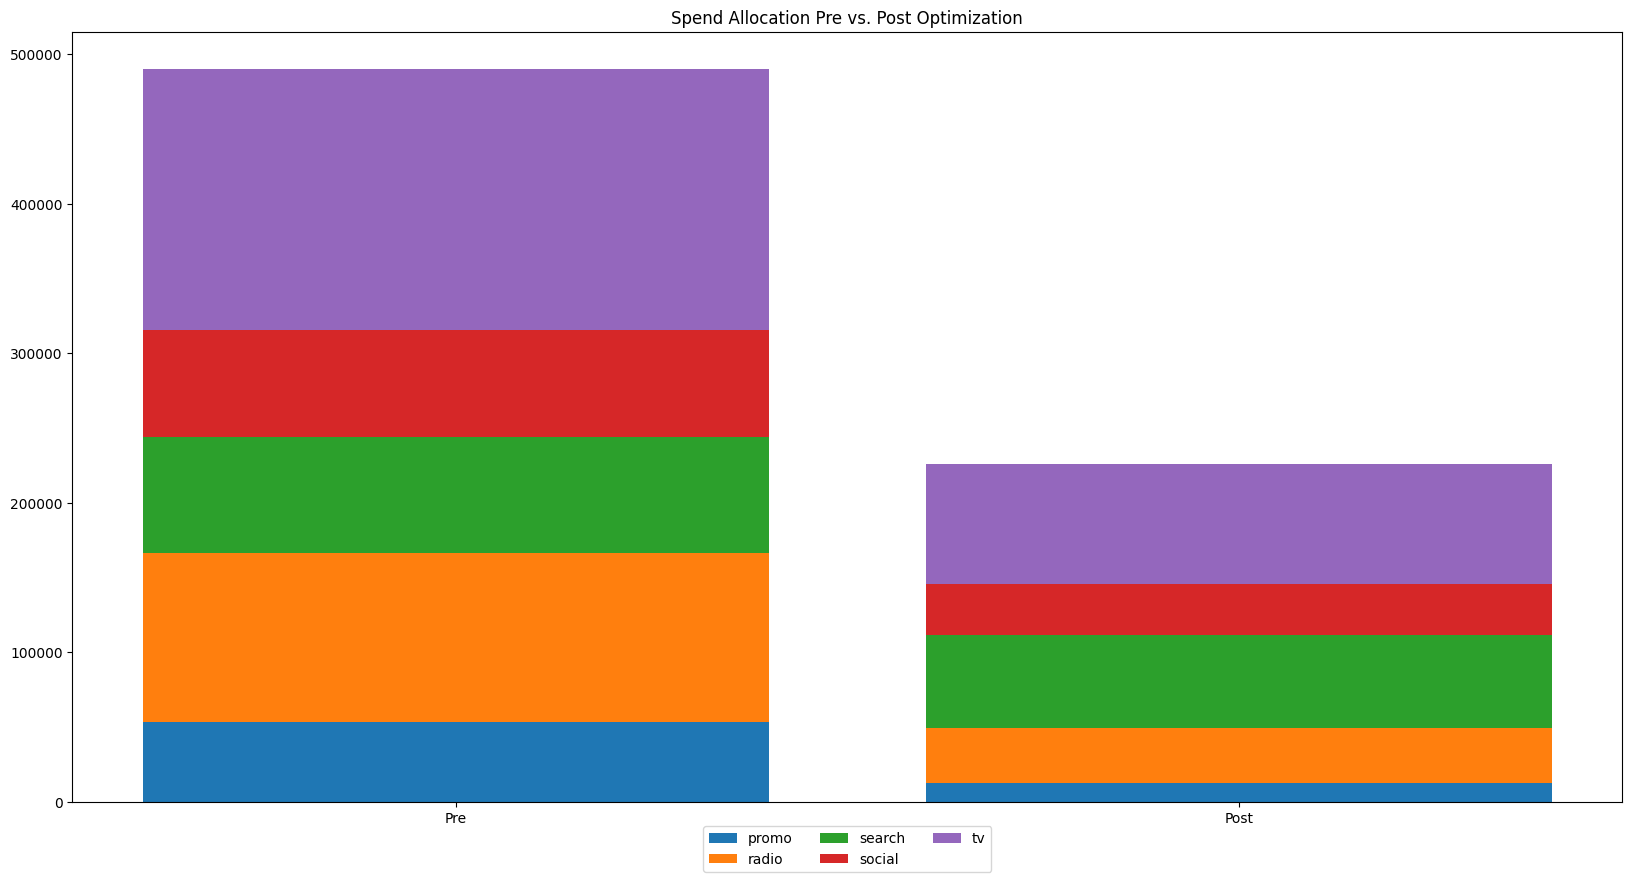

In [59]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=["Pre", "Post"], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

#### Average and Marginal Cost Change

In [60]:
df = mmm.get_raw_df()

In [61]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)
cost_report["ltv"] = ltv_arr
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend,ltv
promo,29.79984,18.77810,33.38452,23.54260,53.30000,12.49423,10.50000
radio,24.80717,16.20323,27.93394,21.07770,112.97900,37.18447,18.50000
search,13.35395,13.19978,14.77021,15.89206,78.03300,61.81514,32.60000
social,20.49716,15.59987,22.68671,20.28789,71.64400,34.30051,20.80000
tv,22.68915,16.52587,24.95373,21.07916,174.55200,80.02915,19.80000


In [62]:
budget_delta = cost_report["post-opt-spend"].values - cost_report["pre-opt-spend"].values
ltv_min_pre_opt_mc = cost_report["ltv"].values - cost_report["pre-opt-marginal-cost"].values

In [63]:
budget_delta

array([-40.80577334, -75.79452876, -16.21785729, -37.34349275,
       -94.52285142])

In [64]:
ltv_min_pre_opt_mc

array([-22.88452012,  -9.43393952,  17.82979293,  -1.88670722,
        -5.15373452])

To validate the result, one should see the patterns:
- when `pre-opt-marginal-cost` is lower than `ltv`, a increase of spend is expected and hence resulting a higher `post-opt-marginal-cost`
- on the contrary, when `pre-opt-marginal-cost` is higher than `ltv`, a decrease of spend is expected and hence resulting a lower `post-opt-marginal-cost`
- if the final `ltv` is still lower than the `post-opt-marginal-cost`, one should always expect zero spend suggested for the channel

### Run optimization with an additional constraint

`.generate_individual_channel_constraints()` is designed to help to generate convenient invidiaul budget constraints with respect to the total budget. For example, by specifying `delta=0.2`, one should expect the total resulting spend of the channel will be within $\pm 20 \%$ of the original budget.

In [15]:
maximizer2 = RevenueMaximizer(
    ltv_arr=ltv_arr,
    model=mmm,
    optim_channel=optim_channels,
    budget_start=budget_start,
    budget_end=budget_end,
    spend_scaler=10.,
)

ind_constraints = maximizer2.generate_individual_channel_constraints(delta=0.2)
maximizer2.add_constraints(ind_constraints)
optim_spend_df2 = maximizer2.optimize(maxiter=1000, eps=1e-3)

new_cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df2,
)
new_cost_report["ltv"] = ltv_arr
new_cost_report

Optimization terminated successfully    (Exit mode 0)
            Current function value: 86833.9468774317
            Iterations: 883
            Function evaluations: 137749
            Gradient evaluations: 883


,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend,ltv
promo,29.79984,26.38747,33.38452,31.10297,53.30000,42.64000,16.50000
radio,24.80717,22.65348,27.93394,26.02684,112.97900,90.38320,24.50000
search,13.35395,14.37820,14.77021,16.45705,78.03300,93.63960,35.60000
social,20.49716,18.60548,22.68671,21.25855,71.64400,57.31520,30.80000
tv,22.68915,20.47835,24.95373,23.22040,174.55200,139.64160,25.80000


In [28]:
new_cost_report["post-opt-spend"].values.sum()

423.61959999993485

In [29]:
new_cost_report["pre-opt-spend"].values.sum()

490.50800000000004

In [18]:
budget_delta = new_cost_report["post-opt-spend"].values - new_cost_report["pre-opt-spend"].values
ltv_min_pre_opt_mc = new_cost_report["ltv"].values - new_cost_report["pre-opt-marginal-cost"].values

In [19]:
budget_delta

array([-10.66  , -22.5958,  15.6066, -14.3288, -34.9104])

In [20]:
ltv_min_pre_opt_mc

array([-16.88452012,  -3.43393952,  20.82979293,   8.11329278,
         0.84626548])

In [ ]:
# Test extra batches dimension for adstock process

In [141]:
# teset create multiple scenarios with (full spend, one-off_1, one-off_2, ...) for the first (batch) dim
spend_matrix = init_spend_matrix
print(spend_matrix.shape)
zero_paddings = np.zeros((maximizer2.n_max_adstock, maximizer2.n_optim_channels))
spend_matrix = np.concatenate([zero_paddings, spend_matrix, zero_paddings], 0)
print(spend_matrix.shape)

# first row always ones
# then rotate the ones on different elements on the last elements
design_broadcast_matrix = np.concatenate(
    [
        np.ones((1, 1, 5)),
        np.expand_dims(np.eye(5), -2),
    ], axis=0
)
print(design_broadcast_matrix.shape)

# duplicate 1 + 5 scanerios
full_sim_sp_matrix = np.tile(np.expand_dims(spend_matrix, 0), reps=(6, 1, 1))
full_sim_sp_matrix = full_sim_sp_matrix * design_broadcast_matrix
print(full_scanerio_spend_matrix.shape)

print(maximizer2.bkg_spend_matrix.shape)
full_sim_sp_matrix += maximizer2.bkg_spend_matrix
full_sim_tran_sp_matrix = adstock_process(
    full_sim_sp_matrix,
    maximizer.optim_adstock_matrix,
)

(31, 5)
(85, 5)
(6, 1, 5)
(6, 85, 5)
(85, 5)


In [147]:
full_tran_sp_matrix = full_sim_tran_sp_matrix[0]
one_off_sp_matrix = full_sim_tran_sp_matrix[1:, ...]

In [148]:
maximizer.optim_sat_array.shape

(5,)

In [157]:
full_comp = np.sum(maximizer.optim_coef_matrix * np.log1p(
            full_tran_sp_matrix / maximizer.optim_sat_array
), -1)
full_comp.shape

(58,)

In [158]:
one_off_comp = np.sum(maximizer.optim_coef_matrix * np.log1p(
            one_off_sp_matrix / maximizer.optim_sat_array
), -1)
one_off_comp.shape

(5, 58)

In [160]:
maximizer.base_comp.shape

(58,)

In [161]:
attr_matrix = np.exp(maximizer.base_comp) * (
    -np.exp(one_off_comp) + np.exp(full_comp)
)

In [162]:
attr_matrix.shape

(5, 58)

In [164]:
# (n_optim_channels, )
revenue = ltv_arr * np.sum(attr_matrix, -1)

In [171]:
# (n_optim_channels, )
cost = np.sum(spend_matrix, 0)
net_profit = np.sum(revenue - cost)
loss = -1 * net_profit / maximizer.response_scaler

In [172]:
loss

-213438.93924075286